In [203]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import json
from pprint import pprint
import pandas as pd
from shapely.geometry import Polygon
import shapely
from sklearn import linear_model
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy import optimize
import pysr
from pysr import PySRRegressor
from IPython.display import display, Math
import torch
from tqdm import tqdm
%matplotlib widget

In [204]:
df = pd.read_csv(
    './data/world_population.csv')
df = df.sort_values(by=['World Population Percentage'],ascending=False)
df[:10]

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
41,1,CHN,China,Beijing,Asia,1425887337,1424929781,1393715448,1348191368,1264099069,1153704252,982372466,822534450,9706961,146.8933,1.0000,17.88
92,2,IND,India,New Delhi,Asia,1417173173,1396387127,1322866505,1240613620,1059633675,870452165,696828385,557501301,3287590,431.0675,1.0068,17.77
221,3,USA,United States,"Washington, D.C.",North America,338289857,335942003,324607776,311182845,282398554,248083732,223140018,200328340,9372610,36.0935,1.0038,4.24
93,4,IDN,Indonesia,Jakarta,Asia,275501339,271857970,259091970,244016173,214072421,182159874,148177096,115228394,1904569,144.6529,1.0064,3.45
156,5,PAK,Pakistan,Islamabad,Asia,235824862,227196741,210969298,194454498,154369924,115414069,80624057,59290872,881912,267.4018,1.0191,2.96
149,6,NGA,Nigeria,Abuja,Africa,218541212,208327405,183995785,160952853,122851984,95214257,72951439,55569264,923768,236.5759,1.0241,2.74
27,7,BRA,Brazil,Brasilia,South America,215313498,213196304,205188205,196353492,175873720,150706446,122288383,96369875,8515767,25.2841,1.0046,2.70
16,8,BGD,Bangladesh,Dhaka,Asia,171186372,167420951,157830000,148391139,129193327,107147651,83929765,67541860,147570,1160.0350,1.0108,2.15
171,9,RUS,Russia,Moscow,Europe,144713314,145617329,144668389,143242599,146844839,148005704,138257420,130093010,17098242,8.4636,0.9973,1.81
131,10,MEX,Mexico,Mexico City,North America,127504125,125998302,120149897,112532401,97873442,81720428,67705186,50289306,1964375,64.9082,1.0063,1.60


In [205]:
cNames = [el for el in df]
CountryNames = df['Country/Territory'].values

In [206]:
name_index = {name_:ind for name_,ind in zip(CountryNames, range(len(df)))}

In [207]:
years_names = cNames[12:4:-1]
years_ = np.array([int(el[:4]) for el in years_names],dtype=np.float64)
years_

array([1970., 1980., 1990., 2000., 2010., 2015., 2020., 2022.])

In [208]:
pops_ = np.zeros(shape=(len(df),len(years_names)))
for i in range(len(df)):
    pops_[i] = df.iloc[i][years_names].values

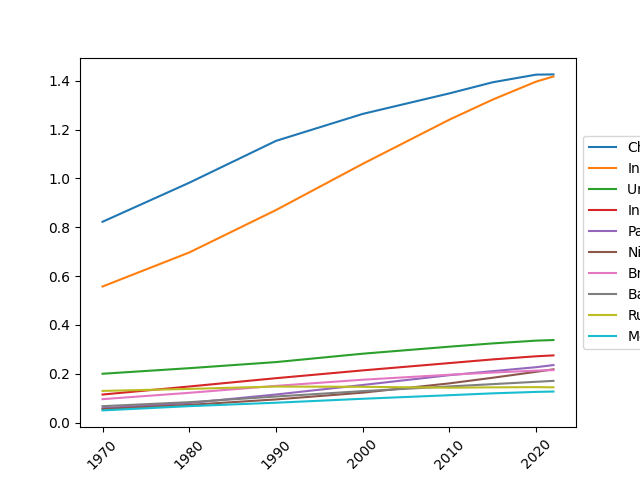

In [209]:
fig,ax = plt.subplots()
for i in range(10):
    ax.plot(years_, pops_[i]/10**9,label=CountryNames[i])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# get velocity per country

In [210]:
velocities_ = []
r2_vec = []
for i in range(len(df)):
    x_ = years_.reshape(-1,1)
    y_ = pops_[i]
    reg = linear_model.Ridge(alpha=.5)
    reg.fit(x_,y_)
    velocities_.append(reg.coef_[0])
    predict_ = reg.predict(x_)
    r2_vec.append(r2_score(y_,predict_))

In [211]:
velocities_[name_index['Russia']]

211930.01181159075

54 234


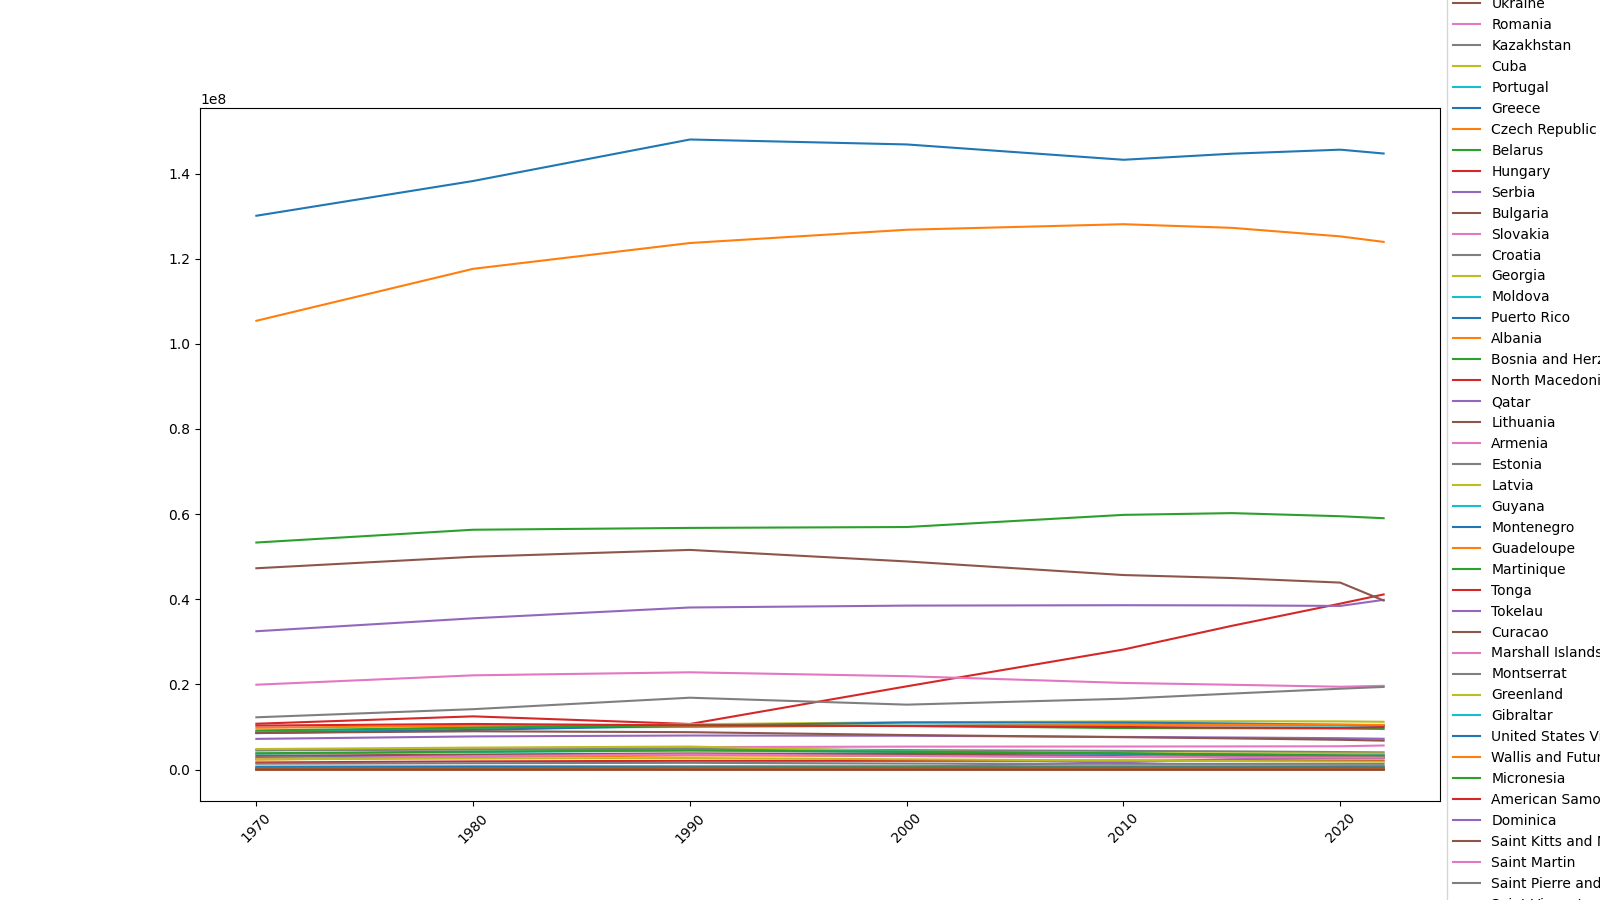

In [212]:
# fig,ax = plt.subplots()
# for i in range(len(df)):
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
cnt_ = 0
for name_,v_,r2 in zip(CountryNames,velocities_,r2_vec):
    if r2 < 0.9:
        ax.plot(years_, pops_[name_index[name_]],label=name_)
        cnt_ +=1
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_yscale('log')
print(cnt_,len(CountryNames))

In [213]:
t_vec =np.copy(years_)

In [214]:
total_N_per_year = np.zeros(shape=(len(t_vec),))
for i in range(len(t_vec)):
    total_N_per_year[i] = np.sum(pops_[:,i])

In [215]:
x_ = [[el] for el in t_vec]


In [216]:
y_ = [el for el in total_N_per_year]


In [217]:
poly = PolynomialFeatures(degree=1, include_bias=False)
poly_features = poly.fit_transform(t_vec.reshape(-1, 1))

0.9997402774341193

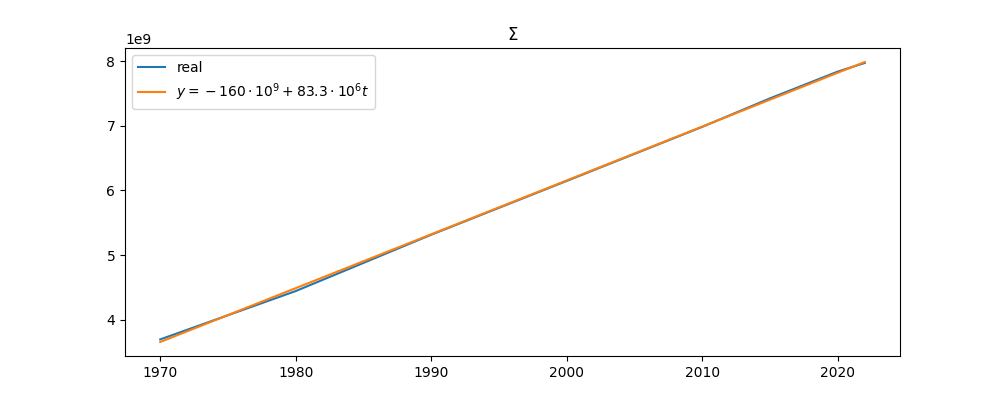

In [218]:
fig,ax = plt.subplots()
fig.set_size_inches(10,4)
ax.plot(t_vec,total_N_per_year,label='real')
ax.set_title(r'$\Sigma$')
# C0 = 186*10**9
# T0 = 2007.0
# y_vec = C0/(T0-t_vec)
# ax.plot(t_vec, y_vec, label=r'$\frac{d}{dt}u = \frac{1}{C_0}u^2$')
# P_vec = 6.463/(1.0+11.926*np.exp(-0.097*(t_vec-1960.0)))*10**9
# ax.plot(t_vec, P_vec ,label =r'$sigma model$')
# ax.set_yscale('log')
reg = linear_model.Ridge(alpha=.5)
reg.fit(x_,y_)
lin_vec = reg.intercept_ + reg.coef_[0]*t_vec
ax.plot(t_vec, lin_vec ,label =r'$y={} \cdot 10^9 +{}\cdot 10^6 t$'.format(str(reg.intercept_/10**9)[:4],str(reg.coef_[0]/10**6)[:4]))
ax.legend()
pred_ = reg.predict(x_)
r2_score(y_,pred_)

In [219]:
x_ = np.array([\
1000.0,
1750.0,
1800.0,
1850.0,
1900.0,
1950.0,
1955.0,
1960.0,
1965.0,
1970.0,
1975.0,
1980.0,
1985.0,
1990.0,
1995.0,
2000.0,
2005.0,
2013.0],np.float64)
y_ = np.array([\
400000.0,
800000.0,
1000000.0,
1262000.0,
1656000.0,
2518629.0,
2755823.0,
3021475.0,
3334874.0,
3692492.0,
4068109.0,
4434682.0,
4830979.0,
5263593.0,
5674380.0,
6070581.0,
6343628.0,
7162119.0
],dtype=np.float64)*1000

In [220]:
dydt_ = np.zeros(shape=(len(y_)-1,))
for i in range(len(dydt_)):
    tau = x_[i+1]-x_[i]
    dydt_[i] = (y_[i+1]-y_[i])/tau

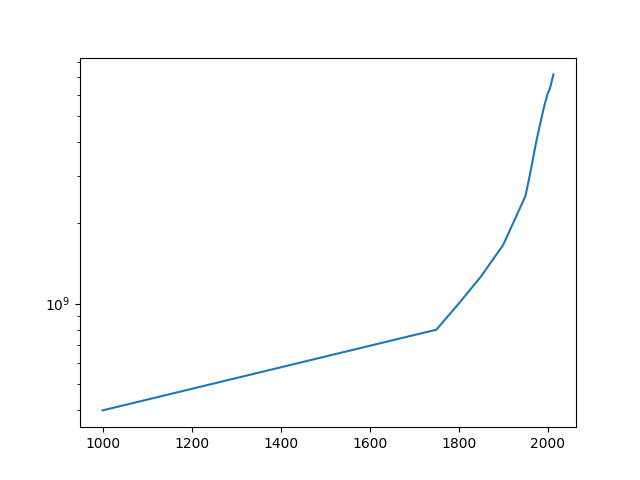

In [221]:
fig,ax =plt.subplots()
ax.plot(x_,y_)
ax.set_yscale('log')

102311375.0


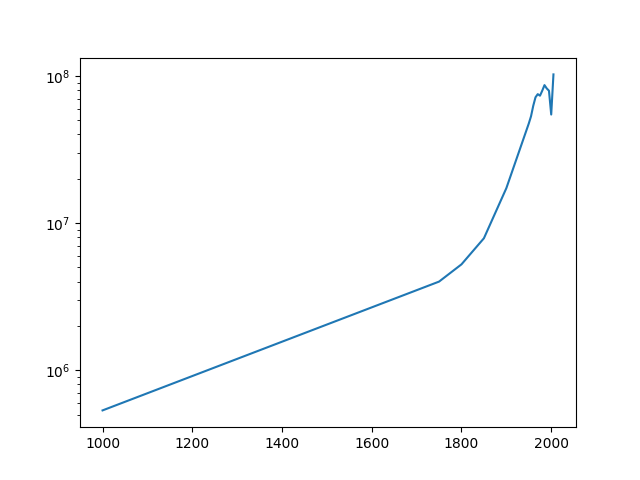

In [222]:
fig,ax =plt.subplots()
ax.plot(x_[:-1],dydt_)
ax.set_yscale('log')
print(np.max(dydt_))

100%|██████████| 100000/100000 [00:26<00:00, 3760.87it/s]


alpha 279.8603820800781 T0 2048.38671875


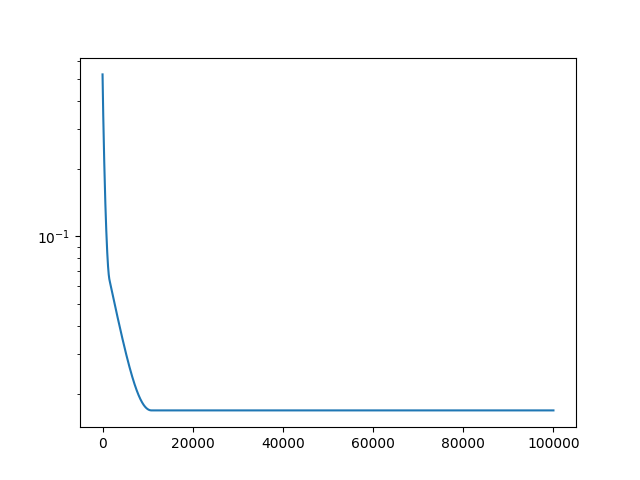

In [223]:
a = torch.tensor([186.0,2015.0]).clone().detach().requires_grad_(True)
x_t = torch.tensor(x_).clone().detach().requires_grad_(False)
y_t = torch.tensor(y_).clone().detach().requires_grad_(False)
z = [a]
last_lr=0.01
optimizer = torch.optim.Adam(z, last_lr, [0.5, 0.7])
EPOCH = 100000
def func(x,params):
    return params[0]*10**9/(params[1]-x)
def loss(x_vec,y_vec,params):
    y_pred = func(x_vec, params)
    return  1.0/len(x_vec)*torch.sum(torch.square(torch.log(y_pred)-torch.log(y_vec)))
loss_vec = []
for i in tqdm(range(EPOCH)):
    if i % 30000==0 and i>0:
        last_lr = last_lr/10.0
        for g in optimizer.param_groups:
            g['lr'] = last_lr
    optimizer.zero_grad()
    loss_ = loss(x_t,y_t, a)  
    loss_for_plot = float(loss_.cpu().detach().numpy())
    loss_vec.append(loss_for_plot)
    loss_.backward()
    optimizer.step()
fig,ax = plt.subplots()
ax.plot(np.arange(EPOCH),loss_vec)
ax.set_yscale('log')
a = a.cpu().detach().numpy()
alpha = a[0]
T0 = a[1]
print(f'alpha {alpha} T0 {T0}')

In [224]:
alpha

279.86038

In [225]:
# alpha_ = 279.86
# T0_=2048.0
# preds_ = alpha_*10**9/(T0_-x_)
preds_ = alpha*10**9/(T0-x_)


In [231]:
alpha/(T0-2043)

51.9537765137781

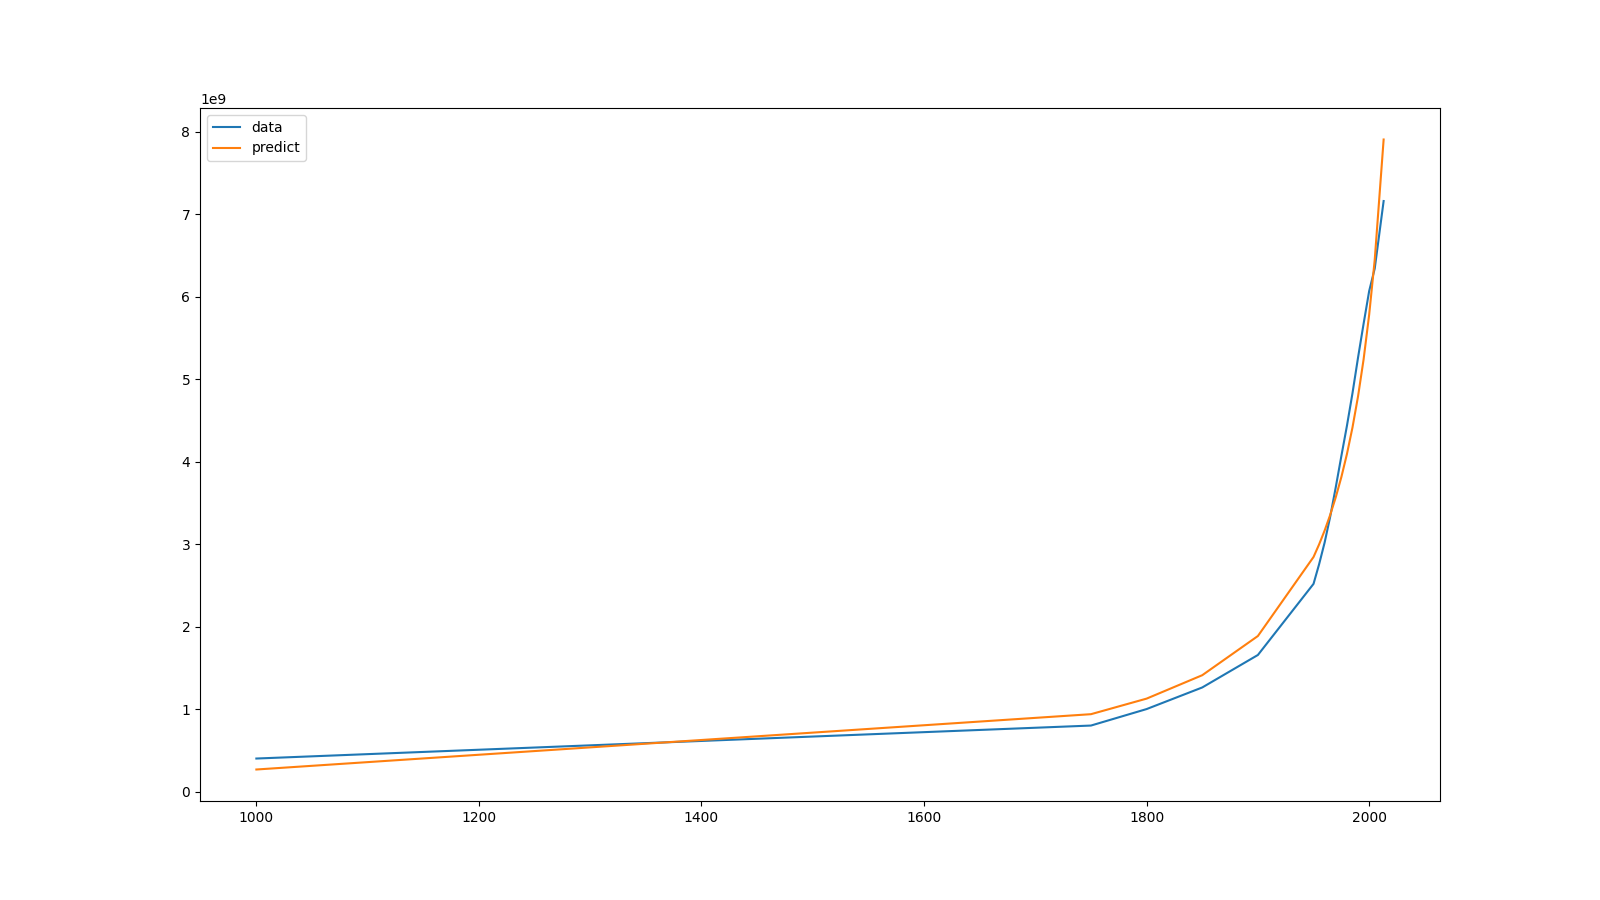

In [232]:
fig,ax =plt.subplots()
fig.set_size_inches(16,9)
ax.plot(x_,y_,label='data')
ax.plot(x_, preds_,label='predict')
# ax.set_yscale('log')
ax.legend()

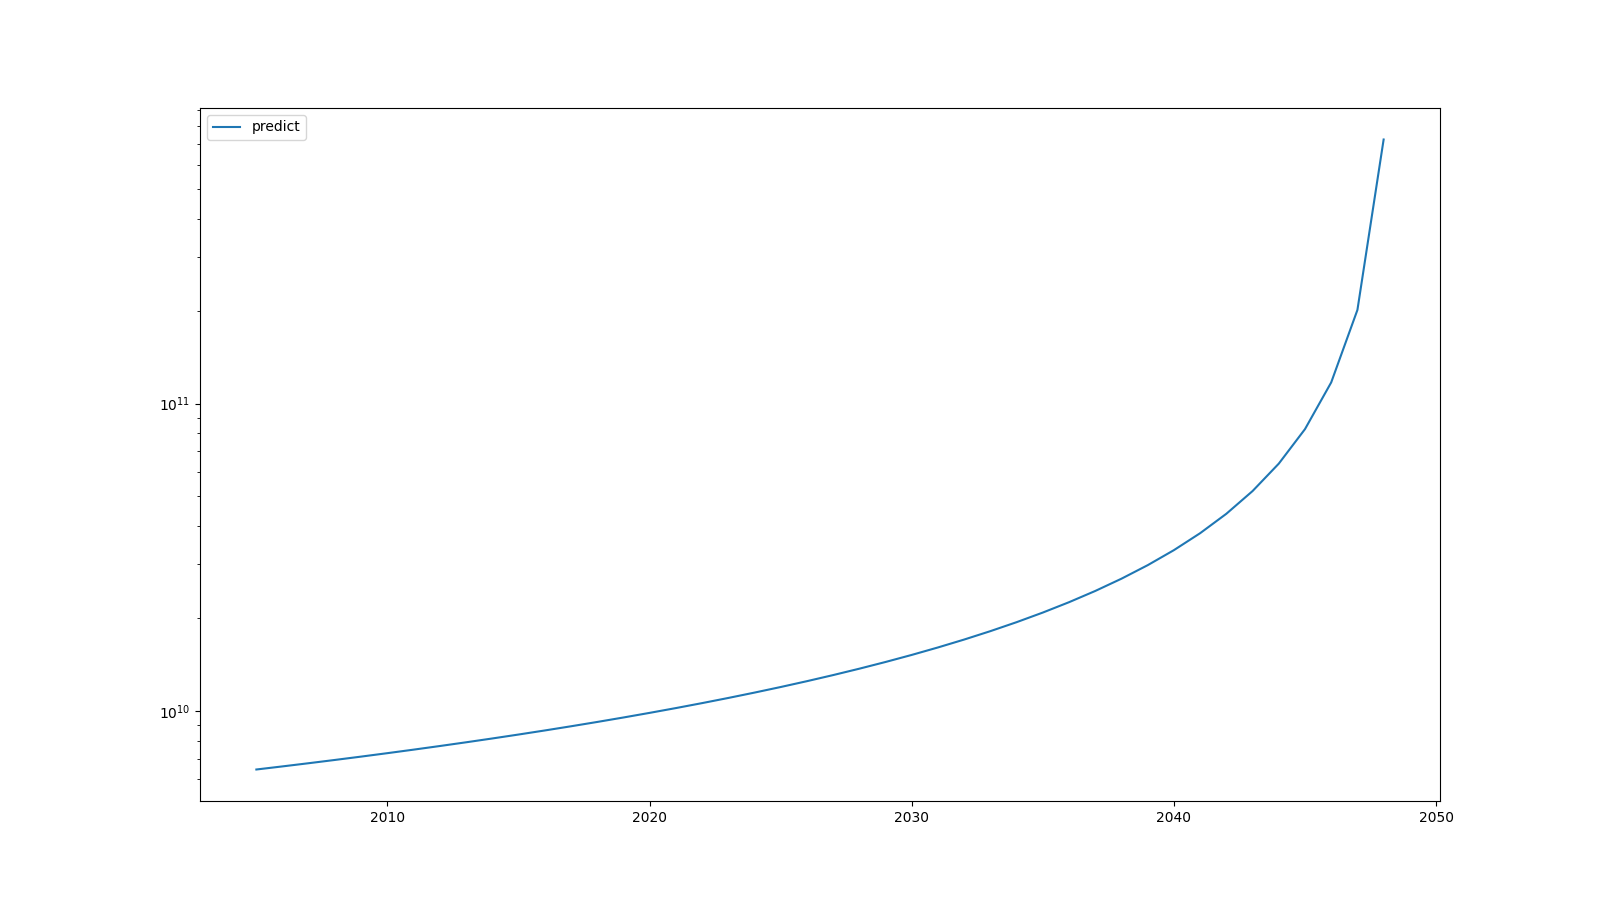

In [236]:
t_ = np.arange(2005, 2049)
preds_ = alpha*10**9/(T0-t_)
fig,ax =plt.subplots()
fig.set_size_inches(16,9)
ax.plot(t_,preds_,label='predict')
ax.set_yscale('log')
ax.legend()